<center><img src="https://github.com/vainero/Files/blob/main/Stock.gif?raw=true"></center>
<h1 style="color:#d16969; font-style:italic; font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px;"> <center>Thanks for visiting my notebook!</center> </h1>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Content</p>
<a href="https://machinelearningknowledge.ai/keras-lstm-layer-explained-for-beginners-with-example/"><img src="https://github.com/vainero/Files/blob/main/LSTM_logo.png?raw=true" width="15%" height="10%" align="right" /></a>


* In this notebook, we will focus on the **[Long Short-Term Memory (LSTM)](https://keras.io/api/layers/recurrent_layers/lstm/)** layer model in **[Keras](https://keras.io/guides/working_with_rnns/)** to predict if the stock will go up or down.

* Historical daliy **[Netflix (NFLX)](https://www.kaggle.com/datasets/meetnagadia/netflix-stock-price-data-set-20022022)** stock price was collected from Yahoo Finance.

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Import Libraries</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Set colors
class color:
    GREEN, RED = '\033[92m', '\033[91m'
    BOLD, UNDERLINE, END = '\033[1m', '\033[4m', '\033[0m'
    GREEN_BOLD = GREEN + BOLD
    RED_BOLD = RED + BOLD
    GREEN_BOLD_UND = GREEN_BOLD + UNDERLINE

rb, gb,  = color.RED_BOLD, color.GREEN_BOLD
gbu, end = color.GREEN_BOLD_UND, color.END

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Loading Data</p>

In [ ]:
data = pd.read_csv('NFLX[1].csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


<div style="border-radius:5px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #145f19;
            letter-spacing:1px;             
            font-size:16px;
            padding: 10px;">

|<font color='#145f19'>Price</font> | <font color='#145f19'>Description</font>
|:--- | :---|
|<font color='darkred'>Open</font>| The price of the stock at the beginning of the trading day
|<font color='darkred'>High</font>| The highest price of the stock on the trading day
|<font color='darkred'>Low</font> | The lowest price of the stock on the trading day
|<font color='darkred'>Close</font>| The last price of the stock before the trading day ends

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [ ]:
# Convert the type of "Date" column into date-time
data["Date"] = pd.to_datetime(data["Date"])
print (data.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [ ]:
# Add the "Year", 'Month' and "Day" columns
data["Year"] = data["Date"].apply(lambda x : str(x)[:4])
data["Month"] = data["Date"].apply(lambda x : str(x)[5:7])
data["Day"] = data["Date"].apply(lambda x : str(x)[8:10])

data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Feature Extraction</p>

In [ ]:
# Print the number of trading days
print(f'{rb}Total number of trading days: {end}{gbu}{data.shape[0]}{end}')
print(f'{rb}Total number of fields: {end}{gbu}{data.shape[1]}{end}')
print('\n')

# Check the Null and NA values
print(f'{rb}Null values: {end}{gbu}{data.isnull().values.sum()}{end}')
print(f'{rb}NA values: {end}{gbu}{data.isna().values.any()}{end}')

Total number of trading days: 5044
Total number of fields: 10


Null values: 0
NA values: False


* We will select from the dataset the **Open** column represents the starting price of the stock for a particular day.

In [ ]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
data = data['Open'].values

# Reshape the data
data = data.reshape(-1, 1)

In [ ]:
# Split the data into training and testing sets
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8):])

* To produce the best-optimized results, we are required to scale the data.

* For this task, we are leveraging scikit-learn library’s **MinMaxScaler()** for converting the input values between 0 to 1.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

* We will create the helper function with 50 timesteps. In other words, for the features(x) we'll append the last 50 prices, and for the label(y) we'll append the next price.

* After that we will convert it into a NumPy array.

In [ ]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [ ]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [ ]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Building Model</p>
* For the LSTM layer, we add **96 units** that represent the dimensionality of the output space.

* The **return_sequences parameter** is set to **True** for returning the last output in output.

* For the Dropout layers, we specify the percentage of layers is **20%** that should be dropped.

* The next step is to add the Dense layer.

In [ ]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [ ]:
# Reshape the feature for the LSTM layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # for expecting 3 dimentions, not 2
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

* We will compile the model with the help of **adam** optimizer.

* The error is computed using **mean_squared_error**.

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Training Model</p>
* With our model and data constructed, we can now train the model.

In [ ]:
# Define modifiable training hyperparameters
epochs = 40
batch_size = 64

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

Epoch 1/40
63/63 [==============================] - 33s 367ms/step - loss: 0.0039
Epoch 2/40
63/63 [==============================] - 24s 379ms/step - loss: 7.4031e-04
Epoch 3/40
63/63 [==============================] - 22s 352ms/step - loss: 5.8314e-04
Epoch 4/40
63/63 [==============================] - 24s 376ms/step - loss: 6.9775e-04
Epoch 5/40
63/63 [==============================] - 24s 375ms/step - loss: 6.4764e-04
Epoch 6/40
63/63 [==============================] - 23s 358ms/step - loss: 5.6351e-04
Epoch 7/40
63/63 [==============================] - 24s 371ms/step - loss: 5.1220e-04
Epoch 8/40
63/63 [==============================] - 24s 385ms/step - loss: 5.4183e-04
Epoch 9/40
63/63 [==============================] - 23s 360ms/step - loss: 6.3038e-04
Epoch 10/40
63/63 [==============================] - 24s 370ms/step - loss: 5.1073e-04
Epoch 11/40
63/63 [==============================] - 24s 380ms/step - loss: 6.3955e-04
Epoch 12/40
63/63 [==============================] - 23s

In [ ]:
# Load the model
model = load_model('stock_prediction')

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Prediction Model</p>

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

30/30 [==============================] - 4s 62ms/step


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Plotting Results</p>

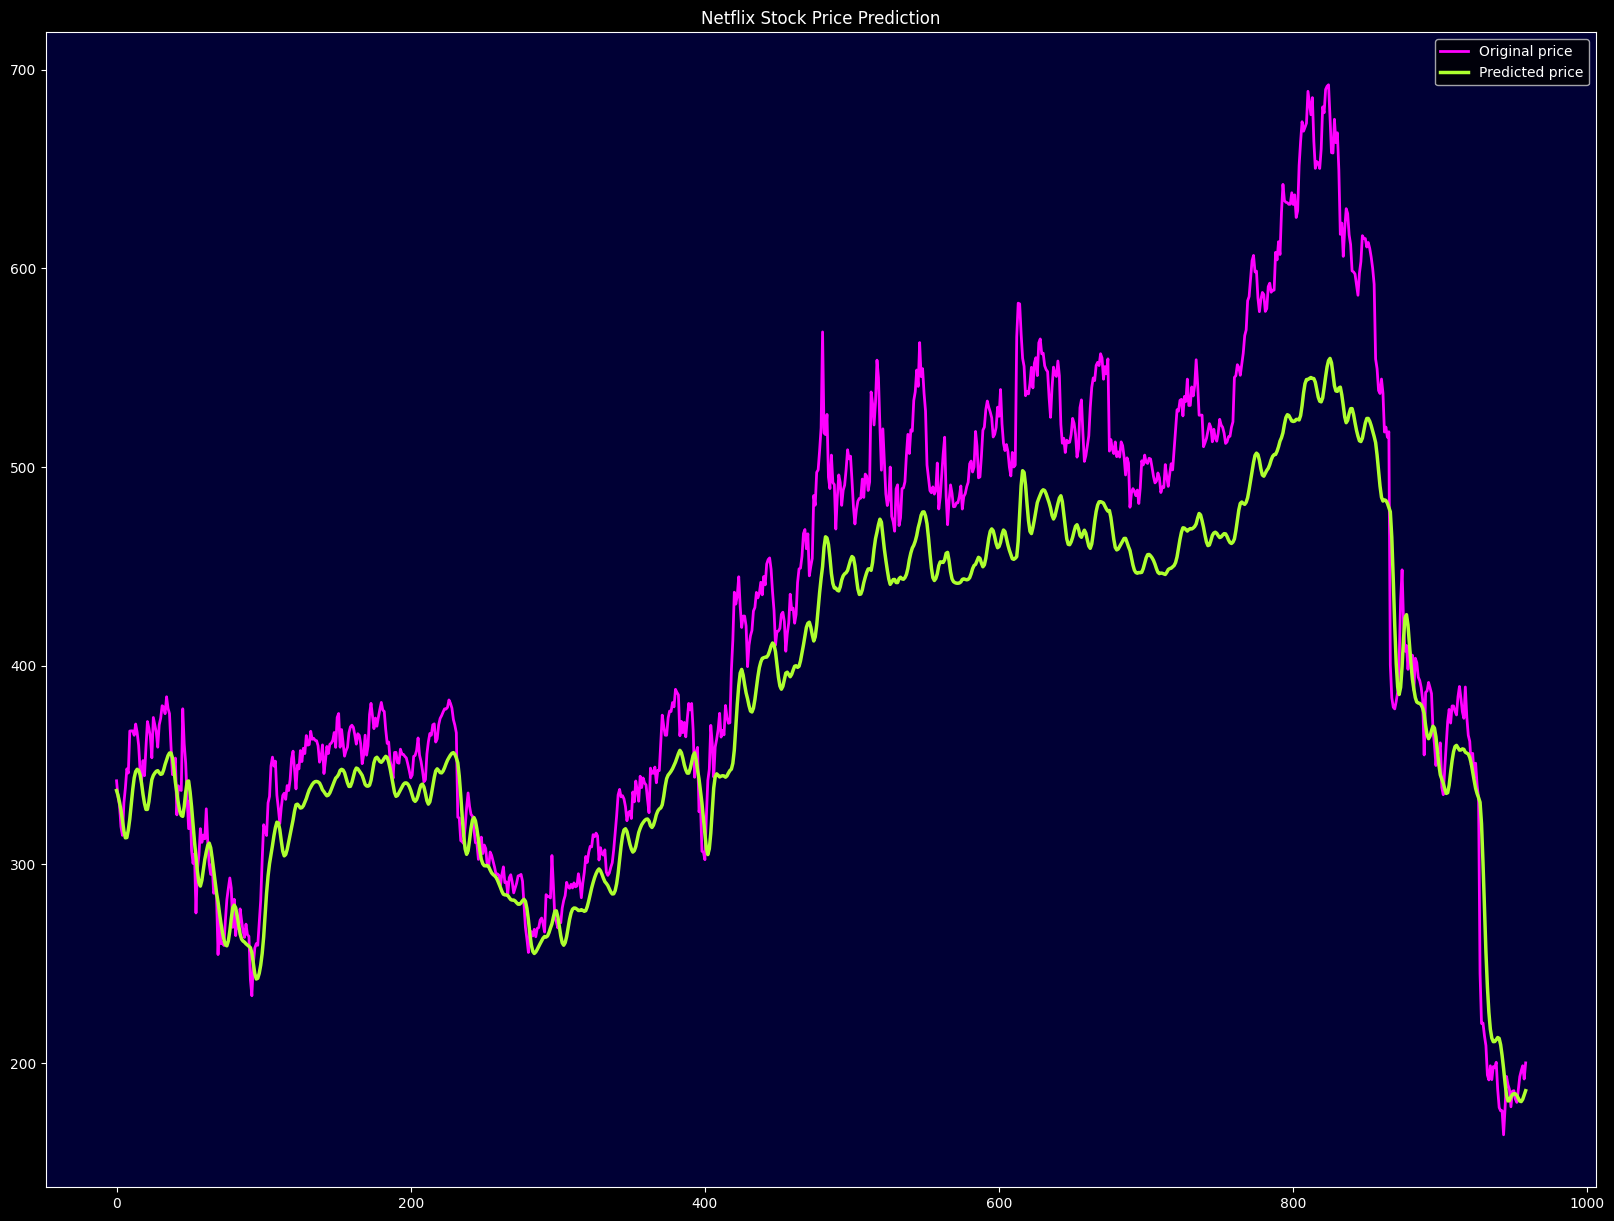

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original price')
plt.plot(predictions, color='greenyellow', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend();

<h3 style="color:#d16969; font-style:italic; font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px;"> <center>Thanks for visiting my notebook!</center> </h3>

<br><center><img src='https://media.giphy.com/media/hpXdHPfFI5wTABdDx9/giphy.gif'
     height=30px width=160px /></center></br>     
     
<h1 style="color:#145f19; font-style:italic; font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px;"> <center>👍 If you find this notebook useful, please support with an upvote 👍</center> </h1>
